# dependencias

In [44]:
from youtube_transcript_api import YouTubeTranscriptApi
import youtube_dl
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from wordcloud import WordCloud
from itertools import combinations
import igraph as ig
import pandas as pd
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcriv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcriv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Introduccion  

## 1.1 descipcion del caso, el numero de videos, palabras luedo de la limpieza 


# tokenizacion 

## 2.1 importacion del texto 

In [45]:
# leer los txt
with open('../input/caso_6.txt', 'r') as f:
    subtitulos_caso_6 = f.read()
with open('../input/caso_7_1.txt', 'r') as f:
    subtitulos_caso_7_lista1 = f.read()
with open('../input/caso_7_2.txt', 'r') as f:
    subtitulos_caso_7_lista2 = f.read()
with open('../input/caso_7_3.txt', 'r') as f:
    subtitulos_caso_7_lista3 = f.read()
subtitulos_caso_7 = '\n'.join([subtitulos_caso_7_lista1,subtitulos_caso_7_lista2,subtitulos_caso_7_lista3])

## 2.2 nomalizacion de los datos

### Funciones necesarias

In [46]:
def normalizacion_regex_texto(texto):
    # Eliminar caracteres o palabras entre [] y ()
    texto = re.sub(r'\[.*?\]', '', texto)
    texto = re.sub(r'\(.*?\)', '', texto)
    # eliminar letras individuales 
    texto = re.sub(r'\b\w\b', '', texto)
    # minimizar, limpieza de espacios, eliminacion de puntuacion  
    palabras = nltk.tokenize.word_tokenize(texto)
    palabras = [palabra.lower() for palabra in palabras if palabra.isalpha()]
    texto = ' '.join(palabras)
    # eliminar acentos o tildes
    texto = re.sub(r'[áéíóúÁÉÍÓÚ]', lambda x: 'aeiouAEIOU'['áéíóúÁÉÍÓÚ'.index(x.group(0))], texto)
    
    return texto

def contar_palabras_con_numeros(texto):
    # Encuentra todas las palabras que contienen al menos un número
    palabras_con_numeros = re.findall(r'\b\w*\d\w*\b', texto)
    
    # Inicializa un diccionario para el conteo de palabras
    conteo_palabras = {}
    
    # Itera sobre las palabras encontradas y cuenta cada una
    for palabra in palabras_con_numeros:
        if palabra in conteo_palabras:
            conteo_palabras[palabra] += 1
        else:
            conteo_palabras[palabra] = 1
    return conteo_palabras

def eliminar_texto_con_numeros(texto):
    texto = re.sub(r'\b\w*\d\w*\b', '', texto)
    return texto

def eliminar_stop_words(texto,stop_words):
    '''eliminar stopwords'''
    palabras = texto.split()
    palabras = [word for word in palabras if word not in stop_words]
    texto = ' '.join(palabras)
    return texto

### implementacion

In [47]:
# conteo de palabras
conteo_palabras_caso_6 = contar_palabras_con_numeros(subtitulos_caso_6[0])
# eliminar texto con numeros
subtitulos_caso_6= eliminar_texto_con_numeros(subtitulos_caso_6.replace('\n',' '))
# normalizar texto
subtitulos_caso_6 = normalizacion_regex_texto(subtitulos_caso_6)
# eliminar stopwords
## cargamos las palabras 
with open('../input/stop_words_taller4.txt','r') as f:
    stop_words = f.read().splitlines()
subtitulos_caso_6 = eliminar_stop_words(subtitulos_caso_6,stop_words)

In [48]:
# conteo de palabras
conteo_palabras_caso_7 = contar_palabras_con_numeros(subtitulos_caso_7[0])
# eliminar texto con numeros
subtitulos_caso_7= eliminar_texto_con_numeros(subtitulos_caso_7.replace('\n',' '))
# normalizar texto
subtitulos_caso_7 = normalizacion_regex_texto(subtitulos_caso_7)
# eliminar stopwords
## cargamos las palabras 
with open('../input/stop_words_taller4.txt','r') as f:
    stop_words = f.read().splitlines()
subtitulos_caso_7 = eliminar_stop_words(subtitulos_caso_7,stop_words)

In [49]:
print(len(subtitulos_caso_7),len(subtitulos_caso_6),sep='\n') # 6/7/7/7

3348267
1481860


## 2.3 analisis de frecuencias

### funciones necesarias

In [100]:
def plot_top_words(text, num_words=100, bar_color='blue', path_guardado=None):
    '''Genera un gráfico de barras con las palabras más comunes en un texto luego de ser limpiado y tokenizado.'''
    # separar el texto en palabras
    words = text.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)

    # Obtener las palabras más comunes
    top_words = word_freq.most_common(num_words)

    # Preparar datos para el gráfico
    words, freq = zip(*top_words)
    
    # Crear el gráfico de barras con el color especificado
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(words)), freq, align='center', color=bar_color)
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()  # Invertir el eje y para que las palabras más comunes estén en la parte superior
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.title(f'Top {num_words} palabras más usadas')
    plt.savefig(path_guardado) # Guardar el gráfico antes de mostrarlo
    plt.show()


def plot_wordcloud(text, max_words=10, color='Accent',path_guardado=None):
    # Genera un contador de las palabras en el texto
    word_counts = Counter(text.split())

    # Obtiene las 'max_words' palabras más comunes
    most_common_words = dict(word_counts.most_common(max_words))

    # Genera la nube de palabras con un solo color
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate_from_frequencies(most_common_words)

    # Crea la figura de Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(path_guardado) # Guardar el gráfico antes de mostrarlo
    plt.show()

# Ahora deberías poder guardar correctamente las imágenes.

### implementacion

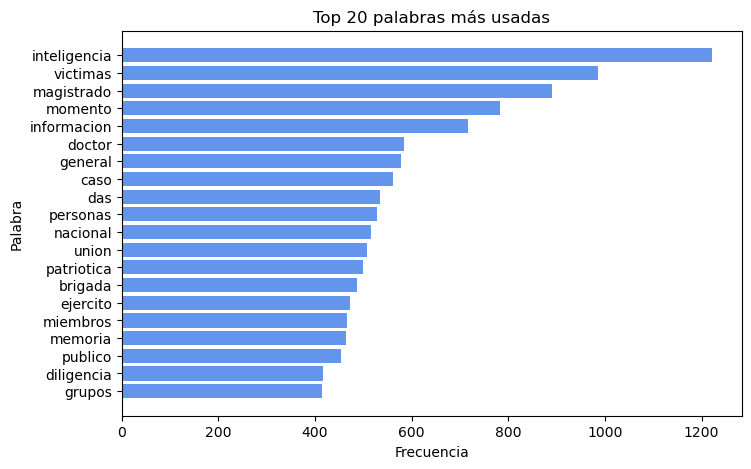

In [101]:
plot_top_words(subtitulos_caso_6,20,'cornflowerblue',path_guardado='../output/taller4_plot/caso_6/palabras_frecuentes_caso_6.png')

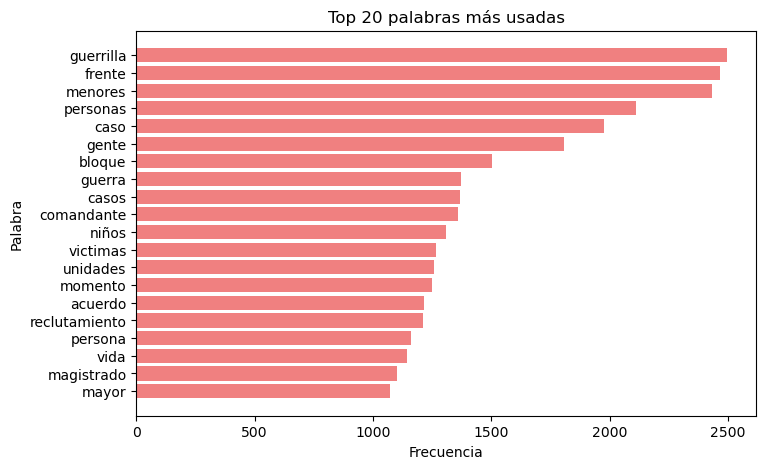

In [102]:
plot_top_words(subtitulos_caso_7,20,'lightcoral',path_guardado='../output/taller4_plot/caso_7/palabras_frecuentes_caso_7.png')

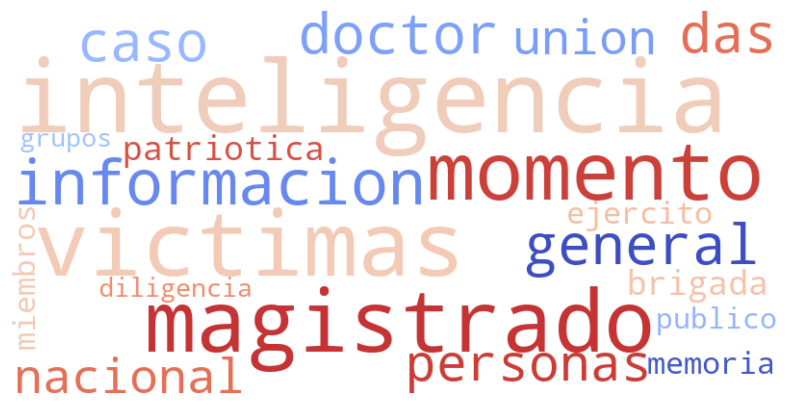

In [111]:
plot_wordcloud(subtitulos_caso_6, max_words=40, color= 'coolwarm',path_guardado='../output/taller4_plot/caso_6/wordcloud_caso_6.png')

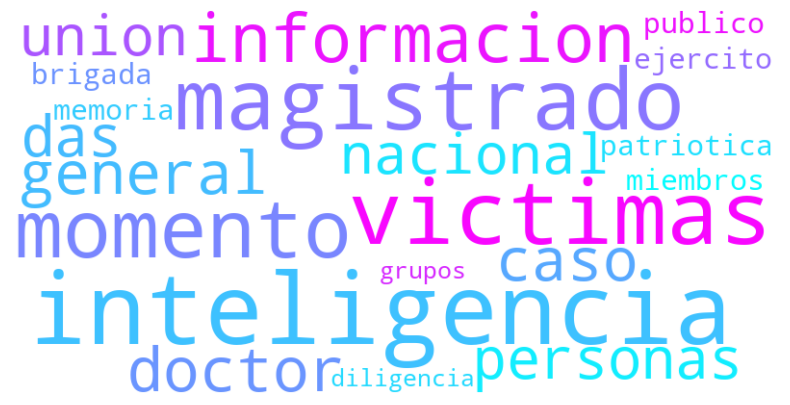

In [112]:
plot_wordcloud(subtitulos_caso_6, max_words=40, color='cool',path_guardado='../output/taller4_plot/caso_7/wordcloud_caso_7.png')

## 2.5 Correlacion de entre los casos

### funciones necesarias

In [127]:
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm

def contar_apariciones(str1, str2):
    return _contar_apariciones_general(str1, str2)

def contar_apariciones_dos_textos(str1, str2):
    return _contar_apariciones_general(str1, str2, common_only=True)

def _contar_apariciones_general(str1, str2, common_only=False):
    # Dividir las cadenas en palabras y convertirlas a minúsculas para evitar distinción entre mayúsculas y minúsculas
    palabras_str1 = str1.lower().split()
    palabras_str2 = str2.lower().split()
    
    # Contar las apariciones de palabras en cada cadena
    contador_str1 = Counter(palabras_str1)
    contador_str2 = Counter(palabras_str2)
    
    # Obtener un conjunto único de todas las palabras
    palabras_totales = set(palabras_str1).union(set(palabras_str2))
    
    # Si solo queremos palabras comunes, utilizar intersección en lugar de unión
    if common_only:
        palabras_totales = set(palabras_str1).intersection(set(palabras_str2))
    
    # Inicializar un diccionario para contar las apariciones de cada palabra en cada cadena
    contador = defaultdict(lambda: {'Frecuencia en str1': 0, 'Frecuencia en str2': 0})
    for palabra in tqdm(palabras_totales, desc="Procesando palabras"):
        contador[palabra]['Frecuencia en str1'] = contador_str1[palabra] / len(palabras_str1),
        contador[palabra]['Frecuencia en str2'] = contador_str2[palabra] / len(palabras_str2),
    
    # Crear DataFrame
    df = pd.DataFrame.from_dict(contador, orient='index').reset_index()
    df.columns = ['Palabra', 'Frecuencia en str1', 'Frecuencia en str2']
    
    return df

### implementacion

In [128]:
resultado_1 = contar_apariciones(subtitulos_caso_6, subtitulos_caso_7)
# Usar la función contar_apariciones_dos_textos
resultado_2 = contar_apariciones_dos_textos(subtitulos_caso_6, subtitulos_caso_7)


Procesando palabras: 100%|██████████| 10661/10661 [00:00<00:00, 119455.01it/s]


In [129]:
resultado_1.sort_values('Frecuencia en str1', ascending=False).head(20)
resultado_1[0:20].to_latex('../output/taller4_plot/tabla_frecuencia_correlacion.tex',index=False)

In [130]:
resultado_2.sort_values('Frecuencia en str2', ascending=False).head(10)
resultado_2[0:20].to_latex('../output/taller4_plot/tabla_frecuencia_correlacion.tex',index=False)

In [59]:
# test de correlacion de pearson
correlation_coefficient, p_value = pearsonr(resultado_2['Frecuencia en str1'], resultado_2['Frecuencia en str2'])

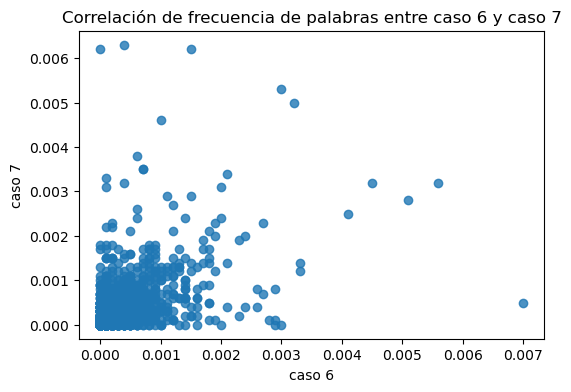

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=resultado_2['Frecuencia en str1'], y=resultado_2['Frecuencia en str2'], alpha= 0.8)
ax.set_xlabel('caso 6')
ax.set_ylabel('caso 7')
#añadimos titulo 
plt.title('Correlación de frecuencia de palabras entre caso 6 y caso 7')
# guardar imagen
plt.savefig('../output/taller4_plot/correlacion.png')


# 4.Bigramas y analisis de grafos

## 4.1 frecuencias

### Funciones 


In [61]:
def Generacion_de_skipgramas(text, n_palabras, k_saltos):
    '''Genera skipgrams de un texto dado con un tamaño de ventana n y un número de skips k.'''
    # Tokenize words
    words = nltk.word_tokenize(text)
    
    # Initialize list to store skipgrams
    skipgrams_list = []
    
    # Generate skipgrams
    for i in range(len(words)):
        # Create combinations of words with skips
        skipgrams = combinations(words[i:i+n_palabras+k_saltos], n_palabras)
        skipgrams_list.extend(skipgrams)
    
    return skipgrams_list

def plot_bigramas(skipgramas, top_n=10):
    # Convertir los bigramas a tuplas ordenadas alfabéticamente
    skipgramas_ordenados = [tuple(sorted(bigram)) for bigram in skipgramas]
    
    # Conteo de bigramas
    conteo_bigramas = Counter(skipgramas_ordenados)

    # Obtener los N bigramas más frecuentes
    bigramas_mas_frecuentes = conteo_bigramas.most_common(top_n)

    # Obtener datos para el gráfico
    bigramas_unicos = [bigrama[0] for bigrama in bigramas_mas_frecuentes]
    frecuencias = [frecuencia for _, frecuencia in bigramas_mas_frecuentes]

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(bigramas_unicos)), frecuencias, tick_label=[f"{bigrama[0]} {bigrama[1]}" for bigrama in bigramas_unicos])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Bigramas')
    plt.ylabel('Frecuencia')
    plt.title(f'Top {top_n} Bigramas más Frecuentes')
    plt.show()

### implementacion

In [62]:
skipgrams_caso_6 = Generacion_de_skipgramas(subtitulos_caso_6, n_palabras=2, k_saltos=0)
skipgrams_caso_7 = Generacion_de_skipgramas(subtitulos_caso_7, n_palabras=2, k_saltos=0)

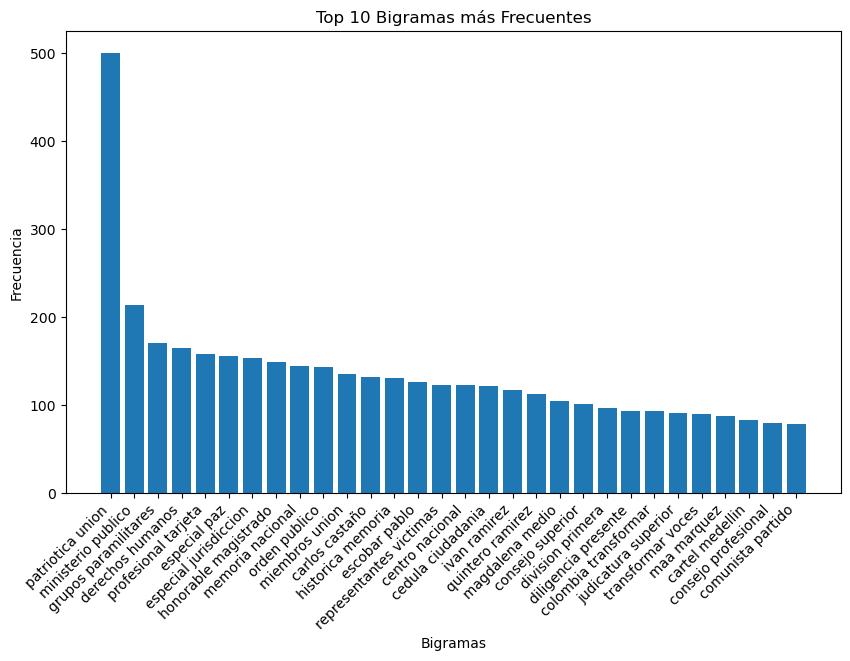

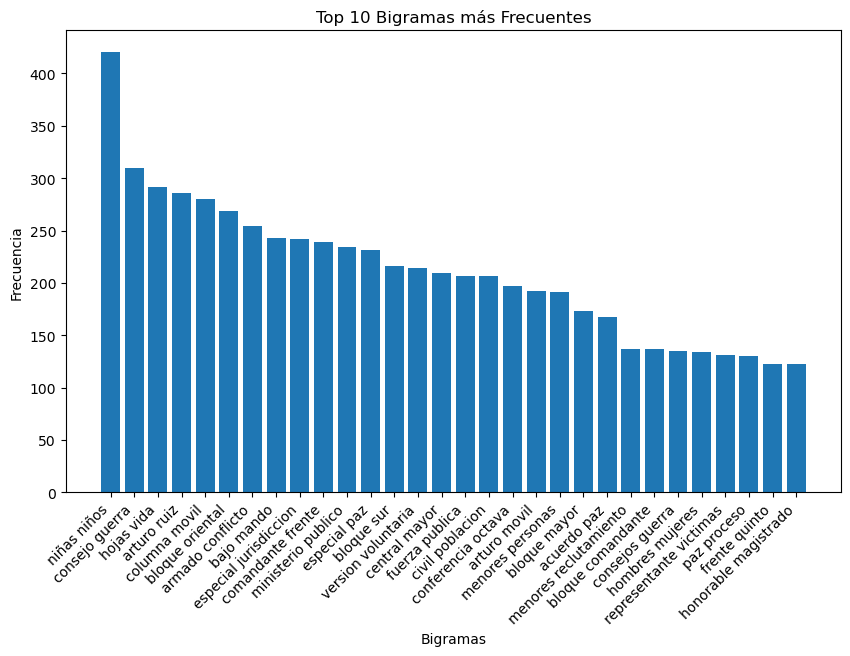

In [63]:
plot_bigramas(skipgrams_caso_6,30)
plot_bigramas(skipgrams_caso_7,30)

## 4.2 grafo bajo umbral 

### funciones


In [64]:
def frecuencia_bigramas(lista_bigramas, umbral):
    # Utilizamos Counter para contar las ocurrencias de las tuplas en la lista
    lista_bigramas = [tuple(sorted(tupla)) for tupla in lista_bigramas]
    contador = Counter(lista_bigramas)
    
    # Filtramos las tuplas que tienen una frecuencia mayor que el umbral
    tuplas_filtradas = [(tupla , frecuencia)for tupla, frecuencia in contador.items() if frecuencia > umbral]
    
    return tuplas_filtradas

def bigramas_para_grafo(lista_bigramas, umbral=10):
    # Utilizamos Counter para contar las ocurrencias de las tuplas en la lista
    lista_bigramas = [tuple(sorted(tupla)) for tupla in lista_bigramas]
    contador = Counter(lista_bigramas)
    
    # Filtramos las tuplas que tienen una frecuencia mayor que el umbral
    tuplas_filtradas = [(tupla ,frecuencia)for tupla, frecuencia in contador.items() if frecuencia > umbral]
    
    return tuplas_filtradas

def creacion_del_grafo(aristas):
    # Crear un grafo
    G = ig.Graph()

    # Conjunto de nodos existentes
    nodos_existentes = set()

    # Añadir las aristas al grafo
    for arista, peso in aristas:
        nodo1, nodo2 = arista

        if nodo1 != nodo2: 

            # Verificar si los nodos ya existen
            if nodo1 not in nodos_existentes:
                G.add_vertex(nodo1)  # Agregar vértice origen
                nodos_existentes.add(nodo1)  # Agregar nodo al conjunto de nodos existentes
            if nodo2 not in nodos_existentes:
                G.add_vertex(nodo2)  # Agregar vértice destino
                nodos_existentes.add(nodo2)  # Agregar nodo al conjunto de nodos existentes

            # Agregar arista con peso
            G.add_edge(nodo1, nodo2, weight=peso)

    return G

### implementacion 

grafo con umbral alto 

In [65]:
bigramas_para_grafos_caso_6 = bigramas_para_grafo(skipgrams_caso_6,100)
bigramas_para_grafos_caso_7 = bigramas_para_grafo(skipgrams_caso_7,50)

In [66]:
print(len(bigramas_para_grafos_caso_6),len(bigramas_para_grafos_caso_7))

21 133


In [67]:
G_caso_6 = creacion_del_grafo(bigramas_para_grafos_caso_6)
G_caso_7 = creacion_del_grafo(bigramas_para_grafos_caso_7)

In [68]:
# grafico de red
# "auto","kk","fr","grid_fr","lgl","rt","circle","shell","spring","spectral"
layout = G_caso_7.layout("fr")


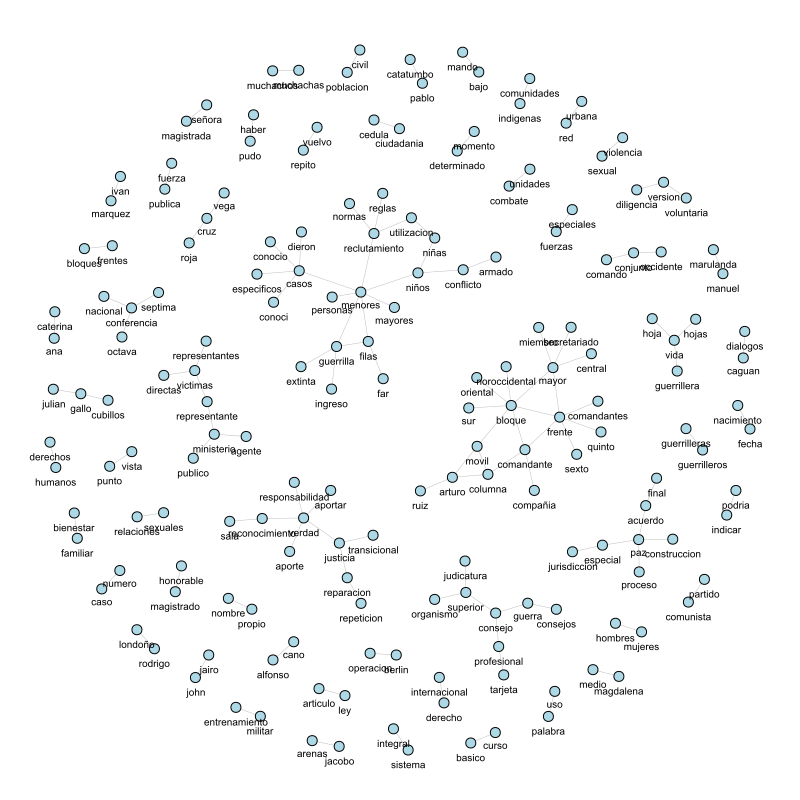

In [69]:
ig.plot(G_caso_7, layout=layout, bbox=(800, 800), margin=50,vertex_size=10,vertex_label_size=10,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=G_caso_7.vs['name'],vertex_color='lightblue',edge_color='gray')

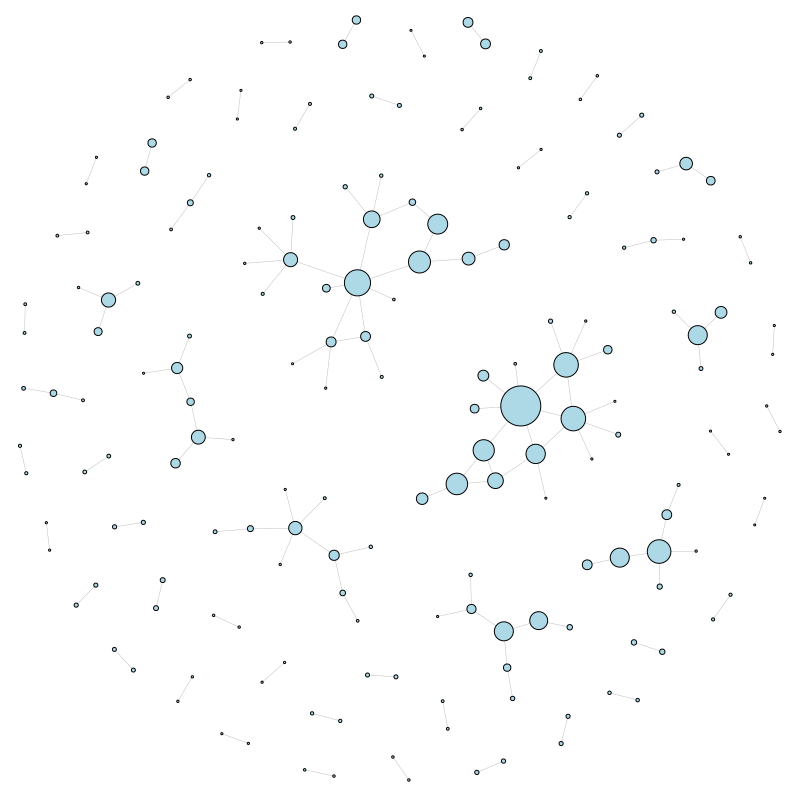

In [70]:
# Calcular la suma de los pesos de las aristas para cada nodo
sum_pesos_aristas = G_caso_7.strength(weights='weight')

# Normalizar la suma de los pesos de las aristas para ajustarla al rango de tamaños de los nodos
max_sum_pesos_aristas = max(sum_pesos_aristas)
sizes = [x / max_sum_pesos_aristas * 40 for x in sum_pesos_aristas]  # Ajusta el rango de tamaño deseado

# Asignar el tamaño calculado a los nodos
G_caso_7.vs["size"] = sizes


# Dibujar el grafo con el layout de Fruchterman-Reingold y etiquetas de nodos
ig.plot(G_caso_7, layout=layout, bbox=(800, 800), margin=20,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')


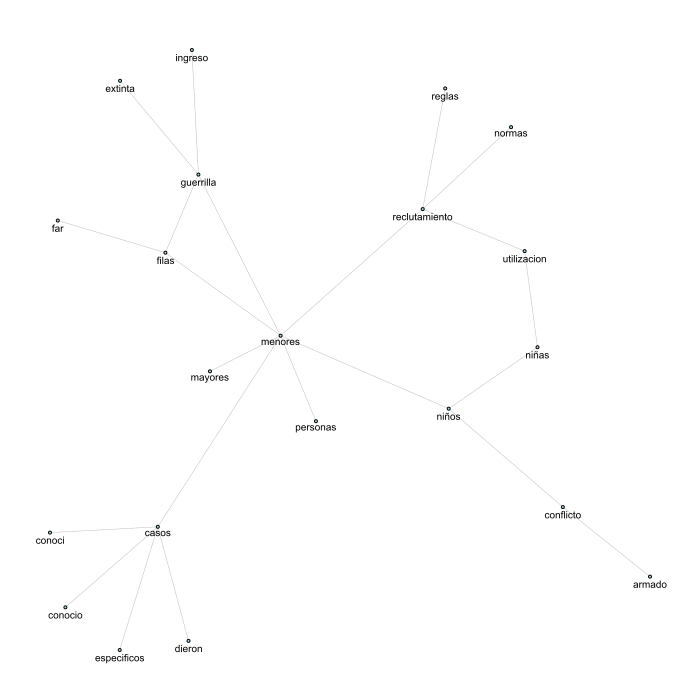

In [71]:
# sacar componente gigante
G_caso_7_gigante = G_caso_7.connected_components().giant()
layout = G_caso_7_gigante.layout("fr")
# Calcular la suma de los pesos de las aristas para cada nodo
sum_pesos_aristas = G_caso_7_gigante.strength(weights='weight')

# Normalizar la suma de los pesos de las aristas para ajustarla al rango de tamaños de los nodos
max_sum_pesos_aristas = max(sum_pesos_aristas)
sizes = [x / max_sum_pesos_aristas * 40 for x in sum_pesos_aristas]  # Ajusta el rango de tamaño deseado
G_caso_7_gigante.vs["size"] = sizes

ig.plot(G_caso_7_gigante, layout=layout, bbox=(700, 700), margin=50,vertex_size=3,vertex_label_size=10,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=G_caso_7_gigante.vs['name'],vertex_color='lightblue',edge_color='gray')

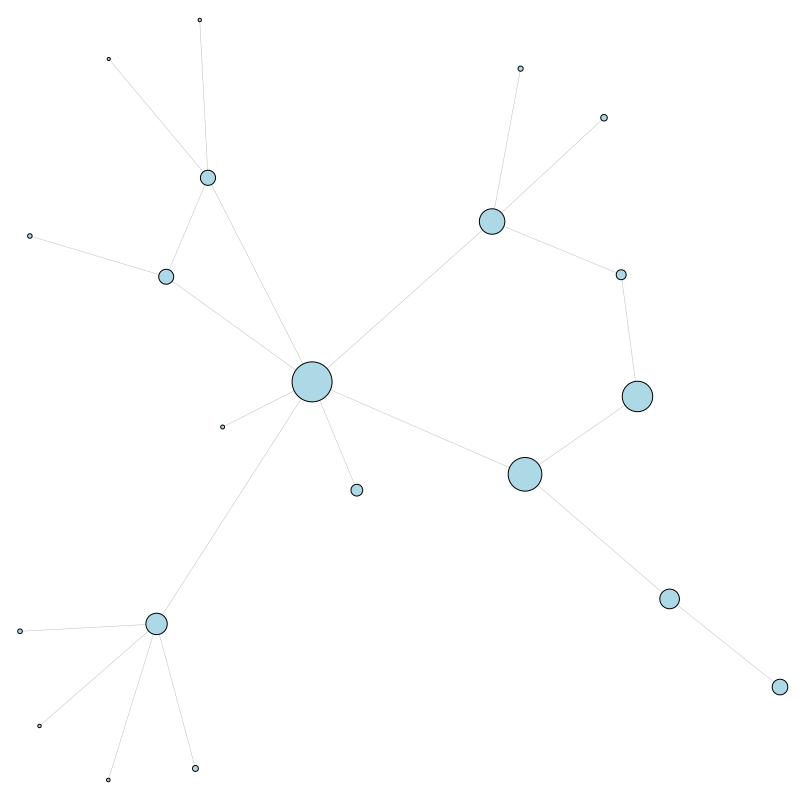

In [72]:
ig.plot(G_caso_7_gigante, layout=layout, bbox=(800, 800), margin=20,vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')

In [73]:
centralidad = G_caso_7_gigante.betweenness(weights='weight')

G_caso_7_gigante.vs['name'],centralidad
# df de centralidad
df_centralidad = pd.DataFrame({'Palabra': G_caso_7_gigante.vs['name'], 'Centralidad': centralidad})

In [74]:
centralidad

[69.0,
 19.0,
 0.0,
 36.0,
 0.0,
 19.0,
 37.0,
 0.0,
 70.0,
 0.0,
 0.0,
 157.0,
 0.0,
 0.0,
 19.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [75]:
# cluster_edge_betweenness
clusters = G_caso_7_gigante.community_edge_betweenness(weights='weight')
clusters = clusters.as_clustering()
print(clusters)  
# clustering = G_caso_7_gigante.transitivity_local_undirected(mode="zero",weights='weight')
# clustering

Clustering with 21 elements and 1 clusters
[0] reclutamiento, utilizacion, niñas, niños, armado, conflicto, guerrilla,
    ingreso, casos, especificos, conoci, menores, personas, normas, filas,
    reglas, mayores, dieron, conocio, far, extinta


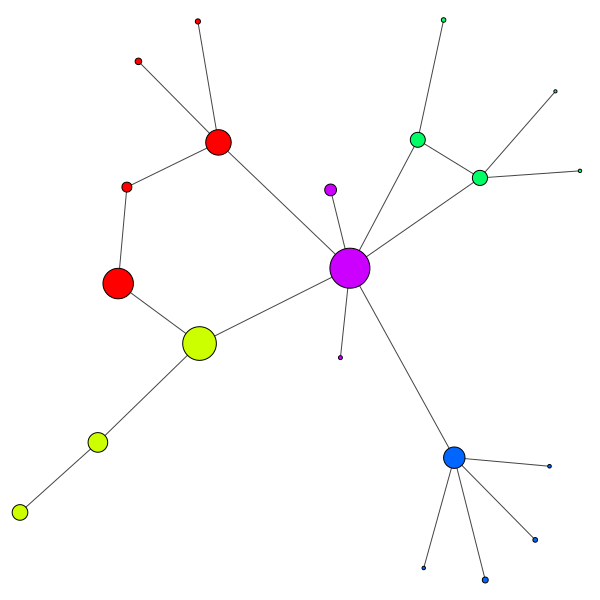

In [76]:
import random
random.seed(42)
# Realizar agrupamiento utilizando el algoritmo de Louvain
clusters = G_caso_7_gigante.community_multilevel()

# Asignar colores a los clusters
palette = ig.RainbowPalette(n=max(clusters.membership) + 1)
colors = [palette.get(int(i)) for i in clusters.membership]

# Dibujar el grafo
layout = G_caso_7_gigante.layout("fr")
ig.plot(G_caso_7_gigante, layout=layout, vertex_color=colors)


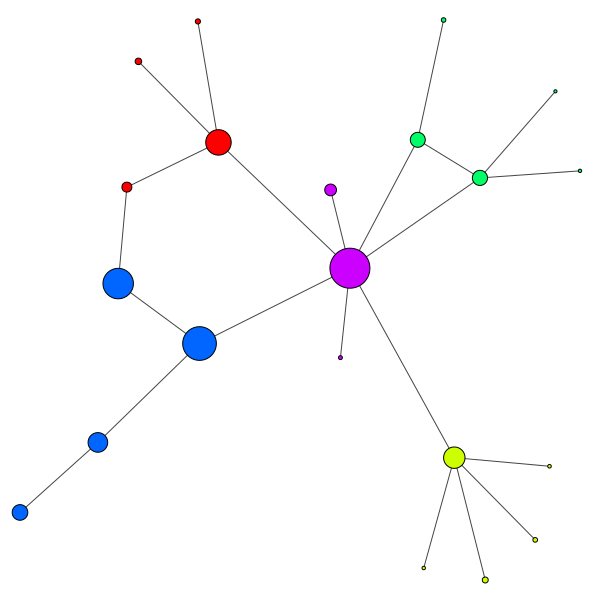

In [77]:
random.seed(42)
clusters = G_caso_7_gigante.community_leading_eigenvector()

# Asignar colores a los clusters
palette = ig.RainbowPalette(n=max(clusters.membership) + 1)
colors = [palette.get(int(i)) for i in clusters.membership]

# Dibujar el grafo

ig.plot(G_caso_7_gigante, layout=layout, vertex_color=colors)

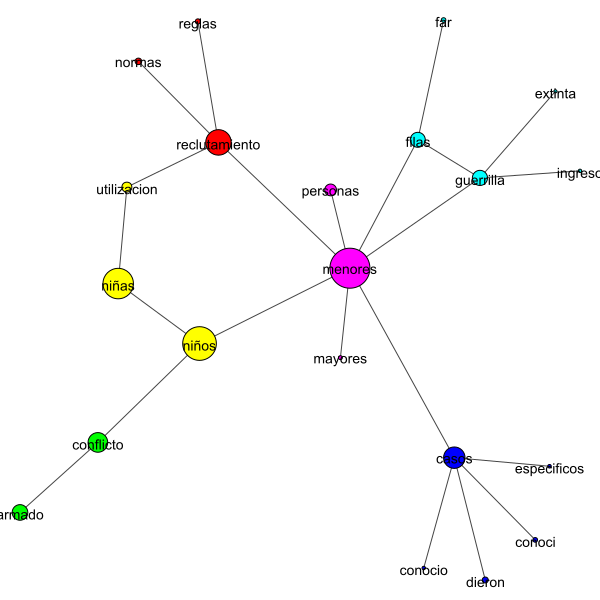

In [78]:
dendrogram = G_caso_7_gigante.community_walktrap()

# Convertir el dendrograma en un objeto VertexClustering
clusters = dendrogram.as_clustering()

# Asignar colores a los clusters
palette = ig.RainbowPalette(n=max(clusters.membership) + 1)
colors = [palette.get(int(i)) for i in clusters.membership]

# Dibujar el grafo
ig.plot(G_caso_7_gigante, layout=layout, vertex_color=colors, vertex_label=G_caso_7_gigante.vs['name'])

In [79]:
clusters.membership

[0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 0, 3, 0, 5, 4, 4, 3, 3]

# 5. analisis de red por video 


In [80]:
def red_por_video (subtitulos):
    '''Genera una red de palabras a partir de una lista de subtítulos.'''
    # limpiar texto y eliminar stopwords
    subtitulos = eliminar_texto_con_numeros(subtitulos.replace('\n',' '))
    subtitulos = normalizacion_regex_texto(subtitulos)
    subtitulos = eliminar_stop_words(subtitulos,stop_words)
    # 10 palabras mas comunes
    words = subtitulos.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words).most_common(10)
    # generar skipgrams
    skipgrams = Generacion_de_skipgramas(subtitulos, n_palabras=2, k_saltos=0)
    # bigramas para grafo
    bigramas_para_grafos = bigramas_para_grafo(skipgrams,100)
    # grafo
    G = creacion_del_grafo(bigramas_para_grafos)
    # componente gigante
    G_gigante = G.connected_components().giant()
    # centralidad
    centralidad = G_gigante.betweenness(weights='weight')
    
    return 

In [81]:
from math import log
import random
palabras_mas_comunes_caso_6 = []
palabras_mas_centralidad_caso_6 = []
estasdisticas_red_caso_6 = []
for i in range(len(subtitulos_caso_6.split('\n'))):
    subtitulo = subtitulos_caso_6.split('\n')[i]
    # limpiar suptitulos, eliminar stopwords y normalizar 
    subtitulo = eliminar_texto_con_numeros(subtitulo)
    subtitulo = normalizacion_regex_texto(subtitulo)
    subtitulo = eliminar_stop_words(subtitulo,stop_words)
    # 5 palabras mas comunes
    # separar el texto en palabras
    words = subtitulo.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)

    # Obtener las palabras más comunes
    palabras_mas_comunes_caso_6.append(word_freq.most_common(5))
    # generar skipgrams
    skipgrams = Generacion_de_skipgramas(subtitulo, n_palabras=2, k_saltos=1)
    # bigramas para grafo
    bigramas_para_grafos = bigramas_para_grafo(skipgrams,int(log((len(skipgrams)))))
    # grafo
    G = creacion_del_grafo(bigramas_para_grafos)
    random.seed(42)
    layout=G.layout("fr")
    ig.plot(G,f'../output/taller4_plot/caso_6/caso_6_video_{str(i)}.png', layout=layout, bbox=(800, 800),vertex_label=G.vs['name'], margin=20,vertex_label_dist=1,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')
    # componente gigante
    G_gigante = G.connected_components().giant()
    # centralidad
    centralidad = G_gigante.betweenness(weights='weight')
    df_centralidad = pd.DataFrame({'Palabra': G_gigante.vs['name'], 'Centralidad': centralidad}).sort_values('Centralidad',ascending=False).head(5)
    palabras_mas_centralidad_caso_6.append(df_centralidad)
    # estadisticas de la red
    # fuerza promedio de los nodos 
    fuerza_promedio = G_gigante.strength(weights='weight')
    fuerza_promedio = np.mean(fuerza_promedio)
    # densidad de la red
    densidad = G_gigante.density()
    # diametro de la red
    diametro = G_gigante.diameter()
    # transitividad global de la red
    transitividad = G_gigante.transitivity_undirected()
    # transversalidad local de la red
    transvers = G_gigante.transitivity_avglocal_undirected()
    # generar diccionario de estadisticas
    estasdisticas_red_caso_6.append({'fuerza_promedio':fuerza_promedio,'densidad':densidad,'diametro':diametro,'transitividad_global':transitividad,'transitividad_local':transvers})


In [82]:
from math import log
import random
palabras_mas_comunes_caso_7 = []
palabras_mas_centralidad_caso_7 = []
estasdisticas_red_caso_7 = []
for i in range(len(subtitulos_caso_7.split('\n'))):
    subtitulo = subtitulos_caso_7.split('\n')[i]
    # limpiar suptitulos, eliminar stopwords y normalizar 
    subtitulo = eliminar_texto_con_numeros(subtitulo)
    subtitulo = normalizacion_regex_texto(subtitulo)
    subtitulo = eliminar_stop_words(subtitulo,stop_words)
    # 5 palabras mas comunes
    # separar el texto en palabras
    words = subtitulo.split(' ')
    words = [word.lower() for word in words if word.isalpha()]
    # Contar la frecuencia de cada palabra
    word_freq = Counter(words)
    # Obtener las palabras más comunes
    palabras_mas_comunes_caso_7.append(word_freq.most_common(5))
    # generar skipgrams
    skipgrams = Generacion_de_skipgramas(subtitulo, n_palabras=2, k_saltos=1)
    # bigramas para grafo
    bigramas_para_grafos = bigramas_para_grafo(skipgrams,int(log((len(skipgrams)/10))))
    # grafo
    G = creacion_del_grafo(bigramas_para_grafos)
    random.seed(42)
    layout=G.layout("fr")
    ig.plot(G,f'../output/taller4_plot/caso_7/caso_7_video_{str(i)}.png', layout=layout, bbox=(800, 800),vertex_label=G.vs['name'], margin=20,vertex_label_dist=1,edge_arrow_size=0.5,edge_width=0.5,vertex_color='lightblue',edge_color='gray')
    # componente gigante
    G_gigante = G.connected_components().giant()
    # centralidad
    centralidad = G_gigante.betweenness(weights='weight')
    df_centralidad = pd.DataFrame({'Palabra': G_gigante.vs['name'], 'Centralidad': centralidad}).sort_values('Centralidad',ascending=False).head(5)
    palabras_mas_centralidad_caso_6.append(df_centralidad)
    # estadisticas de la red
    # fuerza promedio de los nodos 
    fuerza_promedio = G_gigante.strength(weights='weight')
    fuerza_promedio = np.mean(fuerza_promedio)
    # densidad de la red
    densidad = G_gigante.density()
    # diametro de la red
    diametro = G_gigante.diameter()
    # transitividad global de la red
    transitividad = G_gigante.transitivity_undirected()
    # transversalidad local de la red
    transvers = G_gigante.transitivity_avglocal_undirected()
    # generar diccionario de estadisticas
    estasdisticas_red_caso_6.append({'fuerza_promedio':fuerza_promedio,'densidad':densidad,'diametro':diametro,'transitividad_global':transitividad,'transitividad_local':transvers})

KeyboardInterrupt: 